<a href="https://colab.research.google.com/github/anupojuharshita/Lane-Detection/blob/main/HSTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile

zip_path = "/content/combined_dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print("Files inside ZIP:")
    zip_ref.printdir()


Files inside ZIP:
File Name                                             Modified             Size
frame_1810.jpg                                 2025-06-11 13:43:28        47743
frame_1738.jpg                                 2025-06-11 13:43:26        45962
frame_0726.jpg                                 2025-06-11 13:43:22        44134
frame_0240.jpg                                 2025-06-11 13:43:20        41273
frame_1699.jpg                                 2025-06-11 13:43:26        45385
frame_0487.jpg                                 2025-06-11 13:43:20        43618
frame_0204.jpg                                 2025-06-11 13:43:20        42005
frame_0780.jpg                                 2025-06-11 13:43:22        43154
frame_0855.jpg                                 2025-06-11 13:43:22        41390
frame_0516.jpg                                 2025-06-11 13:43:20        46054
frame_0241.jpg                                 2025-06-11 13:43:20        42883
frame_0063.jpg        

In [2]:
dataset_path = "/content"


In [3]:
import zipfile
import os

zip_path = "/content/combined_dataset.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("\n📁 Extracted Folders and Files:")
for root, dirs, files in os.walk(extract_path):
    print("📂", root)
    for file in files[:5]:  # show only first 5
        print(" └──", file)



📁 Extracted Folders and Files:
📂 /content/
 └── frame_1858.jpg
 └── frame_0107.jpg
 └── frame_0919.jpg
 └── frame_1871.jpg
 └── frame_1305.jpg
📂 /content/.config
 └── default_configs.db
 └── config_sentinel
 └── hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 └── gce
 └── .last_survey_prompt.yaml
📂 /content/.config/logs
📂 /content/.config/logs/2025.07.11
 └── 18.44.13.055961.log
 └── 18.44.03.438362.log
 └── 18.43.55.263379.log
 └── 18.44.13.781720.log
 └── 18.44.04.646162.log
📂 /content/.config/configurations
 └── config_default
📂 /content/sample_data
 └── README.md
 └── anscombe.json
 └── mnist_test.csv
 └── california_housing_train.csv
 └── california_housing_test.csv


In [4]:
import torch.nn as nn

class HSTA_MCE(nn.Module):
    def __init__(self):
        super(HSTA_MCE, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 7, padding=3)

        self.attn = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 1),
            nn.Sigmoid()
        )

        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x * self.attn(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.final(x)
        return torch.sigmoid(x)


In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os
import numpy as np
import torch

class CombinedLaneDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = sorted([
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith('.jpg')
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        w, h = img.size
        input_img = img.crop((0, 0, w//2, h))
        mask_img = img.crop((w//2, 0, w, h)).convert("L")  # Grayscale mask

        # Normalize mask to binary 0 or 1
        mask_np = np.array(mask_img)
        mask_np = (mask_np > 127).astype(np.float32)
        mask_img = Image.fromarray((mask_np * 255).astype(np.uint8))

        if self.transform:
            input_img = self.transform(input_img)
            mask_img = self.transform(mask_img)

        return input_img, mask_img

transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor()
])

dataset_path = "/content"  # if you unzipped your dataset here
dataset = CombinedLaneDataset(dataset_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class HSTA_MCE(nn.Module):
    def __init__(self):
        super(HSTA_MCE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 1)  # No sigmoid here
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x  # output logits, no sigmoid


Epoch 1/30 - Loss: 106.9749
Epoch 2/30 - Loss: 80.8617
Epoch 3/30 - Loss: 78.4997
Epoch 4/30 - Loss: 77.0498
Epoch 5/30 - Loss: 75.4767
Epoch 6/30 - Loss: 74.7393
Epoch 7/30 - Loss: 73.4855
Epoch 8/30 - Loss: 72.8869
Epoch 9/30 - Loss: 71.9004
Epoch 10/30 - Loss: 71.7466
Epoch 11/30 - Loss: 71.6395
Epoch 12/30 - Loss: 70.7822
Epoch 13/30 - Loss: 70.3198
Epoch 14/30 - Loss: 70.3511
Epoch 15/30 - Loss: 70.0554
Epoch 16/30 - Loss: 69.5911
Epoch 17/30 - Loss: 69.6255
Epoch 18/30 - Loss: 69.3487
Epoch 19/30 - Loss: 69.0917
Epoch 20/30 - Loss: 68.9902
Epoch 21/30 - Loss: 69.2770
Epoch 22/30 - Loss: 68.4952
Epoch 23/30 - Loss: 68.9291
Epoch 24/30 - Loss: 68.3422
Epoch 25/30 - Loss: 68.0940
Epoch 26/30 - Loss: 67.9895
Epoch 27/30 - Loss: 67.8455
Epoch 28/30 - Loss: 67.6723
Epoch 29/30 - Loss: 67.7547
Epoch 30/30 - Loss: 67.4227


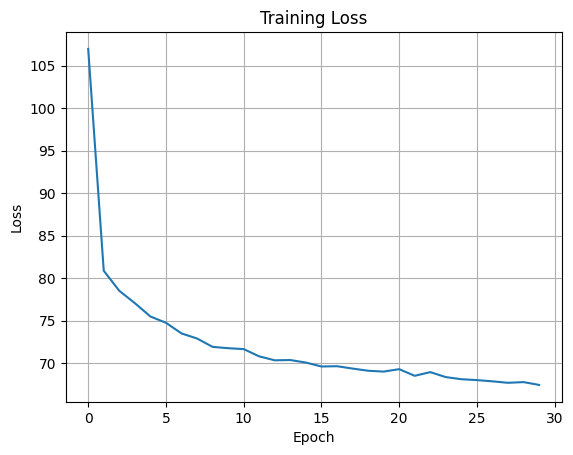

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt

model = HSTA_MCE().cuda()

criterion = nn.BCEWithLogitsLoss()  # Correct for raw output (no sigmoid)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
losses = []

for epoch in range(30):
    model.train()
    total_loss = 0
    for inputs, masks in train_loader:
        inputs, masks = inputs.cuda(), masks.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss)
    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

# Plot loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [8]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, masks in loader:
            inputs, masks = inputs.cuda(), masks.cuda()
            outputs = torch.sigmoid(model(inputs))
            preds = (outputs > 0.5).float()
            correct += (preds == masks).sum().item()
            total += torch.numel(masks)
    acc = 100 * correct / total
    print(f"✅ Model Accuracy: {acc:.2f}%")
    return acc

evaluate_accuracy(model, train_loader)


✅ Model Accuracy: 81.64%


81.64104537963867

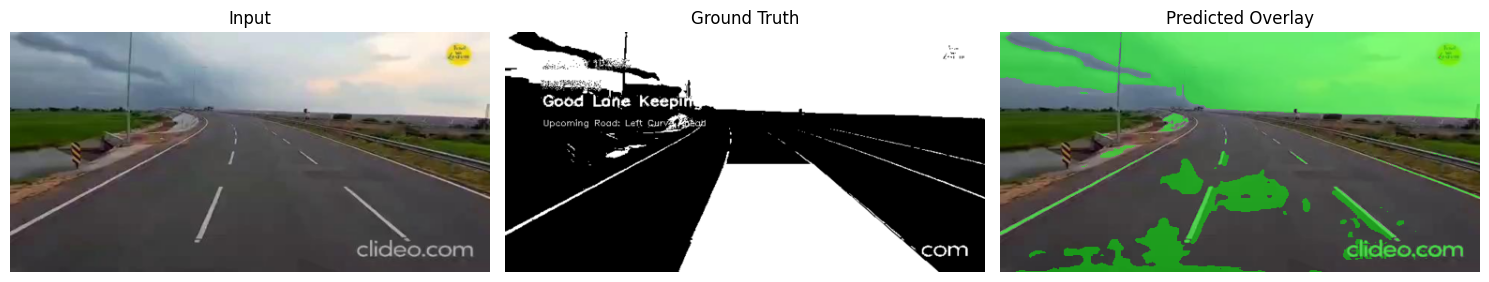

In [10]:
def show_overlay_prediction(model, dataset, idx=0, threshold=0.5):
    import torchvision.transforms.functional as TF
    from PIL import Image
    import matplotlib.pyplot as plt

    model.eval()
    input_tensor, gt_mask = dataset[idx]
    input_batch = input_tensor.unsqueeze(0).cuda()

    with torch.no_grad():
        output = model(input_batch)
        pred_mask = torch.sigmoid(output).squeeze().cpu()
        pred_mask = (pred_mask > threshold).float()

    input_img = TF.to_pil_image(input_tensor)
    gt_img = TF.to_pil_image(gt_mask)
    pred_img = TF.to_pil_image(pred_mask.unsqueeze(0))  # Fix shape for PIL

    # Overlay prediction on input
    green_mask = Image.new("RGB", input_img.size, (0, 255, 0))
    blended = Image.blend(input_img, green_mask, 0.5)
    overlay = Image.composite(blended, input_img, pred_img.convert("1"))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(input_img); plt.title("Input"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(gt_img, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Predicted Overlay"); plt.axis('off')
    plt.tight_layout(); plt.show()

# Try it
show_overlay_prediction(model, dataset, idx=0)
